In [3]:
import os
import uuid
from dotenv import load_dotenv
from typing import List, Annotated
from typing_extensions import TypedDict
from langchain_core.messages import SystemMessage, AIMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from pydantic import BaseModel, Field
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages
from IPython.display import display, Image

In [4]:
load_dotenv()

True

In [ ]:
# 사용자의 요구사항 수집을 위한 시스템 메시지 템플릿 제작
template = """Your job is to get information from a user about what type of prompt template they want to create.

You should get the following information from them:

- What the objective of the prompt is
- What variables will be passed into the prompt template
- Any constraints for what the output should NOT do
- Any requirements that the output MUST adhere to

If you are not able to discern this info, ask them to clarify!
Do not attempt to wildly guess.

After you are able to discern all the information, call the relevant tool.

[IMPORTANT] Your conversation should be in Korean.
Your generated prompt should be in English."""

# 사용자 메시지 목록을 받아서 시스템 메시지와 결합하고 반환
def get_messages_info(messages):
    # 사용자 요구사항 수집을 위해 시스템 메시지를 기존 메시지와 결합한다
    return [SystemMessage(content=template)] + messages

# LLM에 대한 프롬프트 지침을 정의하는 데이터 모델
class PromptInstructions(BaseModel):
    # 완성되어야하는 프롬프트 종류 4가지
    objective : str
    variables : List[str]
    constraints: List[str]
    requirements: List[str]

# LLM 로드
llm = ChatOpenAI(model='gpt-5-nano', temperature=0)
llm_with_tool = llm.bind_tools([PromptInstructions])

# 상태에서 메시지 체인을 생성하고 LLM 호출한다
def info_chain(state):
    messages = get_messages_info(state["messages"])
    response = llm_with_tool.invoke(messages)
    return {"messages":[response]}



In [ ]:
# 메타 프롬프트 작성 (더 채워져야하는 내용을 LLM이 알아서 재질문)
# https://platform.openai.com/docs/guides/prompt-generation?context=text-out
META_PROMPT = """작업 설명이나 기존 프롬프트가 주어졌을 때, 언어 모델이 작업을 효과적으로 완료할 수 있도록 안내하는 상세한 시스템 프롬프트를 작성하십시오.

# 가이드라인

- 작업 이해: 주요 목표, 목표, 요구사항, 제약 조건 및 예상 결과를 파악하십시오.
- 최소 변경: 기존 프롬프트가 제공되는 경우, 간단한 경우에만 개선하십시오. 복잡한 프롬프트의 경우, 명확성을 높이고 원래 구조를 변경하지 않고 누락된 요소를 추가하십시오.
- 결론보다 추론하기**: 결론에 도달하기 전에 추론 단계를 권장합니다. 주의! 사용자가 추론이 나중에 발생하는 예시를 제공하는 경우, 순서를 반대로 하십시오! 절대로 결론부터 예시를 시작하지 마십시오!
- 추론 순서: 프롬프트의 추론 부분과 결론 부분(특정 필드 이름)을 각각 언급하십시오. 각 항목에 대해 추론 순서를 정하고 순서를 반대로 해야 하는지 여부를 결정하십시오.
- 결론, 분류 또는 결과는 항상 마지막에 나와야 합니다.
- 예시: 도움이 된다면 고품질 예시를 포함하고, 복잡한 요소에는 [괄호 안에] 플레이스홀더를 사용하십시오.
- 어떤 종류의 예시를 몇 개 포함해야 하는지, 그리고 플레이스홀더를 활용할 만큼 충분히 복잡한지 여부를 명시하십시오.
- 명확성과 간결성: 명확하고 구체적인 언어를 사용하십시오. 불필요한 지시나 밋밋한 문장은 피하십시오.
- 서식: 가독성을 위해 마크다운 기능을 사용하십시오. 특별히 요청되지 않는 한 ``` 코드 블록은 사용하지 마십시오.
- 사용자 콘텐츠 보존: 입력 작업이나 프롬프트에 광범위한 지침이나 예시가 포함된 경우, 전체적으로 또는 최대한 정확하게 보존하십시오. 모호한 경우 하위 단계로 나누는 것을 고려하십시오. 사용자가 제공한 세부 정보, 지침, 예시, 변수 또는 플레이스홀더는 그대로 유지하십시오.
- 상수: 프롬프트에 상수를 포함하십시오. 상수는 프롬프트 주입에 취약하지 않습니다. 가이드, 루브릭, 예시 등이 있습니다.
- 출력 형식: 가장 적합한 출력 형식을 명확하게 자세히 명시하십시오. 여기에는 길이와 구문(예: 짧은 문장, 단락, JSON 등)이 포함되어야 합니다.
- 잘 정의되거나 구조화된 데이터(분류, JSON 등)를 출력하는 작업의 경우 JSON 출력에 중점을 둡니다.
- 명시적으로 요청되지 않는 한 JSON은 코드 블록(```)으로 감싸서는 안 됩니다.

최종적으로 출력하는 프롬프트는 아래 구조를 따라야 합니다. 추가 설명을 포함하지 말고, 완성된 시스템 프롬프트만 출력하십시오. 특히 프롬프트의 시작이나 끝에 추가 메시지를 포함하지 마십시오. (예: "---" 없음)

[작업을 설명하는 간결한 지침 - 프롬프트의 첫 번째 줄에 있어야 하며, 섹션 헤더는 없어야 합니다.]

[필요에 따라 추가 세부 정보]

[세부 단계를 위한 제목 또는 글머리 기호가 있는 선택 섹션]

# 단계 [optional]

[optional: 작업 완료에 필요한 단계에 대한 자세한 분석]

# 출력 형식

[응답 길이, 구조 등 출력 형식을 구체적으로 명시해야 합니다. 예: JSON, 마크다운 등]

[사용자가 지정한 변수는 {{brackets}}로 묶어야 합니다.]

<Question>
{{question}}
</Question>

<Answer>
{{answer}}
</Answer>

# 예시 [optional]

[optional: 필요한 경우 플레이스홀더가 포함된 1~3개의 명확하게 정의된 예시. 예시의 시작과 끝, 입력 및 출력 내용을 명확하게 표시하십시오. 필요에 따라 사용자 플레이스홀더를 사용하십시오.]
[예시가 실제 예시보다 짧은 경우, ()를 사용하여 실제 예시가 어떻게 더 길어야 하는지, 더 짧아야 하는지, 어떻게 달라야 하는지 설명하는 참고 자료를 작성하십시오. 그리고 플레이스홀더를 사용하십시오!]

# 참고 사항 [optional]

[optional: 예외 상황, 세부 정보, 그리고 특정 중요 고려 사항을 언급하거나 반복할 수 있는 영역]

# 다음 요구 사항을 기반으로 좋은 프롬프트 템플릿을 작성하십시오.

{reqs}
"""

In [6]:
# 메타 프롬프트 작성 (더 채워져야하는 내용을 LLM이 알아서 재질문)
# https://platform.openai.com/docs/guides/prompt-generation?context=text-out
META_PROMPT = """Given a task description or existing prompt, produce a detailed system prompt to guide a language model in completing the task effectively.

# Guidelines

- Understand the Task: Grasp the main objective, goals, requirements, constraints, and expected output.
- Minimal Changes: If an existing prompt is provided, improve it only if it's simple. For complex prompts, enhance clarity and add missing elements without altering the original structure.
- Reasoning Before Conclusions**: Encourage reasoning steps before any conclusions are reached. ATTENTION! If the user provides examples where the reasoning happens afterward, REVERSE the order! NEVER START EXAMPLES WITH CONCLUSIONS!
    - Reasoning Order: Call out reasoning portions of the prompt and conclusion parts (specific fields by name). For each, determine the ORDER in which this is done, and whether it needs to be reversed.
    - Conclusion, classifications, or results should ALWAYS appear last.
- Examples: Include high-quality examples if helpful, using placeholders [in brackets] for complex elements.
   - What kinds of examples may need to be included, how many, and whether they are complex enough to benefit from placeholders.
- Clarity and Conciseness: Use clear, specific language. Avoid unnecessary instructions or bland statements.
- Formatting: Use markdown features for readability. DO NOT USE ``` CODE BLOCKS UNLESS SPECIFICALLY REQUESTED.
- Preserve User Content: If the input task or prompt includes extensive guidelines or examples, preserve them entirely, or as closely as possible. If they are vague, consider breaking down into sub-steps. Keep any details, guidelines, examples, variables, or placeholders provided by the user.
- Constants: DO include constants in the prompt, as they are not susceptible to prompt injection. Such as guides, rubrics, and examples.
- Output Format: Explicitly the most appropriate output format, in detail. This should include length and syntax (e.g. short sentence, paragraph, JSON, etc.)
    - For tasks outputting well-defined or structured data (classification, JSON, etc.) bias toward outputting a JSON.
    - JSON should never be wrapped in code blocks (```) unless explicitly requested.

The final prompt you output should adhere to the following structure below. Do not include any additional commentary, only output the completed system prompt. SPECIFICALLY, do not include any additional messages at the start or end of the prompt. (e.g. no "---")

[Concise instruction describing the task - this should be the first line in the prompt, no section header]

[Additional details as needed.]

[Optional sections with headings or bullet points for detailed steps.]

# Steps [optional]

[optional: a detailed breakdown of the steps necessary to accomplish the task]

# Output Format

[Specifically call out how the output should be formatted, be it response length, structure e.g. JSON, markdown, etc]

[User given variables should be wrapped in {{brackets}}]

<Question>
{{question}}
</Question>

<Answer>
{{answer}}
</Answer>

# Examples [optional]

[Optional: 1-3 well-defined examples with placeholders if necessary. Clearly mark where examples start and end, and what the input and output are. User placeholders as necessary.]
[If the examples are shorter than what a realistic example is expected to be, make a reference with () explaining how real examples should be longer / shorter / different. AND USE PLACEHOLDERS! ]

# Notes [optional]

[optional: edge cases, details, and an area to call or repeat out specific important considerations]

# Based on the following requirements, write a good prompt template:

{reqs}"""

In [10]:
# 도구 호출 이후의 메시지만 가져온다
def get_prompt_messages(messages: list):
    tool_call = None
    other_msgs = []             # 도구 호출 이후의 메시지 저장 리스트
    for m in messages:              # 메시지 목록 순회
        if isinstance(m, AIMessage) and m.tool_calls:           # AI 메시지에서 도구호출 있으면 도구호출정보 저장
            tool_call = m.tool_calls[0]["args"]
        elif isinstance(m, ToolMessage):                # ToolMessage는 스킵
            continue
        elif tool_call is not None:                     # 도구 호출 이후의 메시지를 리스트에 추가
            other_msgs.append(m)
    # 시스템 메시지와 도구 호출 이후의 메시지를 결합해서 반환
    return [SystemMessage(content=META_PROMPT.format(reqs=tool_call))] + other_msgs

# 프롬프트 생성 체인
def prompt_gen_chain(state):
    messages = get_prompt_messages(state["messages"])
    response = llm.invoke(messages)
    return {"messages":[response]}

In [11]:
# 상태 결정 함수
def get_state(state):
    messages = state["messages"]
    if isinstance(messages[-1], AIMessage) and messages[-1].tool_calls:
        return "add_tool_message"
    elif not isinstance(messages[-1], HumanMessage):
        return END
    return "info"

In [17]:
# State 생성
class State(TypedDict):
    messages: Annotated[list, add_messages]

memory = MemorySaver()          # 대화내용 기록

# 상태그래프 생성
workflow = StateGraph(State)

# 노드 추가
workflow.add_node("info", info_chain)
workflow.add_node("prompt", prompt_gen_chain)
@workflow.add_node
def add_tool_message(state : State):            # 도구 메시지 추가 노드
    return {
        "messages": [
            ToolMessage(
                content="Prompt generated!",
                tool_call_id=state["messages"][-1].tool_calls[0]["id"]
            )
        ]
    }

# 엣지로 노드를 연결 (info -> add_tool_messages 또는 info 또는 END 로 이동)
# get_state 리턴 결과에 따라 이동
workflow.add_edge(START, "info")
workflow.add_edge("add_tool_message", "prompt")
workflow.add_conditional_edges("info", get_state, 
                               ["add_tool_message", "info", END])
workflow.add_edge("prompt", END)

# 상태그래프 만들고 노드 만들고 엣지로 연결했으면 컴파일한다
graph = workflow.compile(checkpointer=memory)

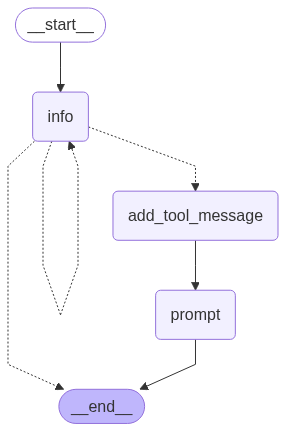

In [18]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
from langchain_teddynote.messages import stream_graph

config = {"configurable": {"thread_id" : str(uuid.uuid4())}}

while True:
    try:
        user = input("User (q/Q to quit): ")
    except:
        pass

    print(f"\n[사용자] {user}")

    if user in {"q", "Q"}:
        print("종료합니다")
        break

    output = None
    stream_graph(graph, {"messages": [HumanMessage(content=user)]},
                 config=config,
                 node_names=["info", "prompt"]
                 )


[사용자] RAG 프롬프트를 만들고 싶어요

🔄 Node: info 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
좋아요! RAG 프롬프트를 구체적으로 설계하려면 몇 가지 정보를 부탁드려요. 아래 질문에 답해주시면, 그 정보를 바탕으로 영어 프롬프트 템플릿을 만들어 드리고 필요한 규칙도 반영해 드리겠습니다.

1) 프롬프트의 목표(목적)에는 어떤 작업을 수행하게 하고 싶으신가요?
- 예: 사용자의 질의에 대해 관련 문서를 검색해 요약하고, 출처를 인용해서 최종 답변을 제공합니다. 등.

2) 프롬프트 템플릿에 어떤 변수들이 들어가길 원하나요? 가능하면 구체적으로 적어주세요.
- 예: user_query, retrieved_docs(리스트 형태로 각 항목에 content, title, source, score 포함), top_k, user_profile, conversation_history, 도메인 특이 지식 등의 변수.

3) 출력에 대해서 피해야 할 것(출력에 포함되지 않도록 해야 하는 내용)이나 제약은 무엇인가요?
- 예: 허구 정보 금지, 특정 형식이나 길이 제한, 특정 언어/톤 강제, 비공개 데이터 노출 금지, 출처를 반드시 인용해야 함 등.

4) 출력이 반드시 지켜야 할 요구사항은 무엇인가요?
- 예: 형식(예: 요약 + 답변 + 출처 목록), 언어, 길이 제한, 근거 제공 방식(링크/인용 표기), 응답의 신뢰도 표시(자신감 점수) 등.

추가로 고려하면 좋은 항목
- 데이터 소스 표기 방식: 출처를 어떤 형식으로 표기할지(예: [Source: URL], 근거 문서 제목 + URL 등)
- RAG 파이프라인의 역할 분담: 리트리벌/랭크/합성 중 어떤 부분이 프롬프트의 관심사인지
- 출력 형식 예시가 있다면 간단히 알려주시면 템플릿에 반영하기가 쉽습니다.

답변 주시면, 위 정보를 바탕으로 영어로 된 프롬프트 템플릿(템플릿 구조와 예시 포함)으로 정리해 드리고, 필요하다면 한 번에 실행 가능한 프롬프